#PhoBERT: Pre-trained language models for Vietnamese

* We apply the pretrained PhoBERT model, the first public large-scale monolingual language models pre-trained for Vietnamese, particularly the PhoBERT-base.

* PhoBERT pre-training approach is based on RoBERTa which optimizes the BERT pre-training procedure for more robust performance. 

* PhoBERT outperforms previous monolingual and multilingual approaches, obtaining new state-of-the-art performances on four downstream Vietnamese NLP tasks of Part-of-speech tagging, Dependency parsing, Named-entity recognition and Natural language inference.

This post will explain how you can modify and fine-tune PhoBERT base to create a powerful NLP model that quickly gives you state of the art results.

First, we should note why we need fine-tuning technique?

#Advantages of Fine-Tuning 

In this tutorial, we will use PhoBERT to train a text classifier. Specifically, we will take the pre-trained PhoBERT model, add an untrained layer of neurons on the end, and train the new model for our classification task. Why do this rather than train a train a specific deep learning model (a CNN, BiLSTM, etc.) that is well suited for the specific NLP task you need?

1. Quicker Development

First, the pre-trained PhoBERT model weights already encode a lot of information about Vietnamese language. As a result, it takes much less time to train our fine-tuned model - it is as if we have already trained the bottom layers of our network extensively and only need to gently tune them while using their output as features for our classification task. In fact, the authors recommend only 2-4 epochs of training for fine-tuning BERT on a specific NLP task (compared to the hundreds of GPU hours needed to train the original PhoBERT model or a LSTM from scratch!).


2. Less Data

In addition and perhaps just as important, because of the pre-trained weights this method allows us to fine-tune our task on a much smaller dataset than would be required in a model that is built from scratch. A major drawback of NLP models built from scratch is that we often need a prohibitively large dataset in order to train our network to reasonable accuracy, meaning a lot of time and energy had to be put into dataset creation. By fine-tuning BERT, we are now able to get away with training a model to good performance on a much smaller amount of training data.

3. Better Results

Finally, this simple fine-tuning procedure (typically adding one fully-connected layer on top of PhoBERT and training for a few epochs) was shown to achieve state of the art results with minimal task-specific adjustments for a wide variety of tasks: classification, language inference, semantic similarity, question answering, etc. Rather than implementing custom and sometimes-obscure architetures shown to work well on a specific task, simply fine-tuning PhoBERT is shown to be a better (or at least equal) alternative.


# Setup
## Using Colab GPU for Training

Google Colab offers free GPUs and TPUs! Since we’ll be training a large neural network it’s best to take advantage of this (in this case we’ll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

Edit => Notebook => Settings => Hardware accelerator => (GPU)

You can connect to your google drive by:





In [ ]:
# to connect with your google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
Then run the following cell to confirm that the GPU is detected.

In [ ]:
CUDA_LAUNCH_BLOCKING="1"
#Confirm that GPU is accepted
try:
  %tensorflow_version 2.x
except:
  pass
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


## Installing the Hugging Face Library

Next, let’s install the transformers package from Hugging Face which will give us a pytorch interface for working with BERT. We’ve selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don’t provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task. For example, in this tutorial we will use `BertForSequenceClassification.`

The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.

To load model PhoBERT we need to install the following pakages:

* `fairseq`: a Facebook's project to support researches and projects relating to the `seq2seq` model.

* `fastBPE`: a package supports to tokenize words into subwords by following the latest method applied for modern pre-trained NLP models, for instant BERT and BERT's versions. 

* `vncorenlp`: a NLP package in Vietnamese, supports to tokenization and other NLP's functions. It was published by the PhoBERT's authors.

* `transformers`: a project of huggingface, it supports to train models by basing on the tranformer's design, for instance  BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet, T5, CTRL,... serves for NLP's missions both on pytorch and tensorflow.

In [ ]:
!pip install vncorenlp
!pip install transformers
!pip install fairseq
!pip install fastBPE

     |████████████████████████████████| 2.6 MB 4.1 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=ca11cc451cb79f6630738e4c07b343c345be35d2e1e7c0b80e32d7cda16576cb
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp
     |████████████████████████████████| 2.8 MB 2.8 MB/s 
     |████████████████████████████████| 895 kB 43.6 MB/s 
     |████████████████████████████████| 3.3 MB 33.5 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 636 kB 43.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.7 MB 3.7 MB/s 
     |████████████████████████████████| 145 kB 44.6 MB/s 
     |████████████████████████████████| 90 kB 9.7 MB/s 
     |████████████████████████████████| 74

  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp37-cp37m-linux_x86_64.whl size=483113 sha256=75e6960774ae9a18bea644200b3a1d914866bea019995f9b1402f7b8c7a51988
  Stored in directory: /root/.cache/pip/wheels/bd/d4/0e/0d317a65f77d3f8049fedd8a2ee0519164cf3e6bd77ef886f1
Successfully built fastBPE


Next, we need to dowload pre-trained models from PhoBERT!!! 

It includes 3 files: bpe.codes, dict.txt, model.pt having the following functions:

* bpe.codes: BPE token which PhoBERT model used to encode the sentence into the index. 
* dict.txt: the dictionary of training dataset.
* model.pt: model saved on pytorch.

# Tokenization & Input Formatting

In this section, we’ll transform our dataset into the format that BERT can be trained on.

## PhoBERT Tokenizer

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with PhoBERT–the below cell will download this for us. We’ll be using the `fastBPE` which PhoBERT used. 

Below is a guide to install VnCoreNLP, we can download it from the origial repo of PhoBERT.

In [ ]:
# text into tokens
import vncorenlp
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("/content/gdrive/MyDrive/BERTsequence_classification/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

To be sure it works, we can test with a simple sentence to tokenize it into tokens.

In [ ]:
text = "Chất lượng sản phẩm rất kém. Hàng rất tệ tôi rất muốn trả hàng. Shopee có thể giúp ko?!" 

# Print the original sentence.
print(' Original: ', text)

# Print the sentence split into tokens.
print('Tokenized: ', rdrsegmenter.tokenize(text))

# Print the sentence mapped to token ids.
#print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Chất lượng sản phẩm rất kém. Hàng rất tệ tôi rất muốn trả hàng. Shopee có thể giúp ko?!
Tokenized:  [['Chất_lượng', 'sản_phẩm', 'rất', 'kém', '.'], ['Hàng', 'rất', 'tệ', 'tôi', 'rất', 'muốn', 'trả', 'hàng', '.'], ['Shopee', 'có_thể', 'giúp', 'ko', '?'], ['!']]


We dowloaded above the vocabularies of PhoBERT, "`bpe.codes`" and `vocab.txt`, now we install them as follow.

In [ ]:
from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import  Dictionary
import argparse

In [ ]:
# Creating Byte Pair Encoding for PhoBERT

parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes',default="/content/gdrive/MyDrive/BERTsequence_classification/bpe.codes",
    required=False,
    type=str,  
    help='path to fastBPE BPE')
args, unknown = parser.parse_known_args()

#Incorporate the BPE encoder into PhoBERT
phoBERT_bpe = fastBPE(args)

#Load dictionary
vocab = Dictionary()
vocab.add_from_file("/content/gdrive/MyDrive/BERTsequence_classification/vocab.txt")

Now, we can use `PhoBERT_bpe` to encode a sentence or a paragraphe into a list of subwords, `vocab` supports you decoding subworbs into theirs ids in the provided vocabulary named `vocab.txt`, published by PhoBERT's author.

Let's try with an example!

In [ ]:
tokens = phoBERT_bpe.encode('Trang rất là dễ_thương!')
print('tokens list : ', tokens)

# Decode into the sentence from the index tokens
tokens_id = vocab.encode_line('<s>' + 'Trang rất là dễ_thương!' + '</s>') 
print('tokens ids : ',tokens_id)

tokens list :  Trang rất là dễ@@ _th@@ ương@@ !
tokens ids :  tensor([64000,    59,     8, 64002,     2], dtype=torch.int32)


#Data prepararion
## Reading data

We aim to separate the IDs, Labels and the Texts which include the negative or positive comments of clients . The text is gonna be segmented at this step also. 

First, we read the training dataset, pre-processing is done by using `wordsegmenter`. 

Note: In case the input texts are raw, i.e, without word segmentation, a word segmenter must be applied to produce word-segmented texts before feeding to PhoBERT employed the RDRSegmenter from VnCoreNLP to pre-process the pre-training data, it is recommended to also use the same word segmenter for PhoBERT-based downstream applications w.r.t the input raw texts.

In [ ]:
import re
train_path = '/content/gdrive/MyDrive/BERTsequence_classification/Data/train.crash'

train_id, train_text, train_label = [],[],[]
test_id, test_text = [], []

with open(train_path, 'r') as f_r:
  data = f_r.read().strip()

  data = re.findall('train_[\s\S]+?\"\n[01]\n\n', data)

  for sample in data:
    splits = sample.strip().split('\n')

    id = splits[0]
    label = int(splits[-1])
    text = ' '.join(splits[1:-1])[1:-1]
    text = rdrsegmenter.tokenize(text)
    text = ' '.join([' '.join(x) for x in text])

    train_id.append(id)
    train_text.append(text)
    train_label.append(label)

Ok, now we have a list including tokenized data corresponding to its label list involving labels `0` and `1`. So let't see the tokenization as our unique pre-process.

`train_text` looks like below,

In [ ]:
# try to see the first client's comment and its label. 
print(train_text[0])
print(train_label[0])

Dung dc sp tot cam on shop Đóng_gói sản_phẩm rất đẹp và chắc_chắn Chất_lượng sản_phẩm tuyệt_vời
0


## Spliting data into the training and validation set 

Divide up our training set to use 90% for training and 10% for validation.

In [ ]:
from sklearn.model_selection import train_test_split

train_sents, val_sents, train_labels, val_labels = train_test_split(train_text, train_label,test_size=0.1, random_state=42)

## Input Formatting

Before we are ready to encode our text, though, we need to decide on a maximum sentence length for padding / truncating to. 

Just in case there are some longer test sentences, I’ll set the maximum length to 125.

From these raw data (through the tokenization step during readind data), we use `phoBERT_bpe` loaded above to exchange input text into subworbs and encode them to indexes in the vocabulary of PhoBERT.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_LEN = 125

train_ids = []

for sent in train_sents:
  subwords = '<s>' + phoBERT_bpe.encode(sent) + '</s>'
  encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False)
  train_ids.append(encoded_sent)


val_ids = []
for sent in val_sents:
  subwords = '<s> ' + phoBERT_bpe.encode(sent) + '</s>'
  encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False)
  val_ids.append(encoded_sent)

train_ids = pad_sequences(train_ids, maxlen = MAX_LEN, dtype = "long", value=0, truncating="post")
val_ids = pad_sequences(val_ids, maxlen = MAX_LEN, dtype = "long", value=0, truncating="post")

train_ids now becomes a list of training data samples, where each sample is a id list of subworbs belonging to the vocabulary. The sentences which are shorter than 125 subworbs, are padded 0 at the end. Another ones which are longer than 125, are cutted to guarante enough 125 subworbs. 

Then we create a mask including values 0 and 1, to be the input for tranformers's library. This mask points our which values of a array being padded. 

In [ ]:
train_masks = []
for sent in train_ids:
  mask = [int(token_id > 0) for token_id in sent]
  train_masks.append(mask)

val_masks = []
for sent in val_ids:
  mask = [int(token_id > 0) for token_id in sent]

  val_masks.append(mask)

The prepared input data is almost done, we only change them to tensor and use DataLoader of torch to create dataloader.

In [ ]:
# Convert the lists into tensors
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch

train_inputs = torch.tensor(train_ids)
val_inputs = torch.tensor(val_ids)

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)


We’ll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size = 32)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size = 32)

# Train Our Classification Model

Finally the data preparation is done, we comeback the mission of loading PhoBERT model. Here, we use PhoBERT base with the tranformer option of Hugging Face (in fact, we have two options to load PhoBERT model, one is fairseq and another is Tranformers, you can read more with these keywords on the internet).

## RobertaForSequenceClassification
For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task.

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaConfig, AdamW

config = RobertaConfig.from_pretrained("/content/gdrive/MyDrive/BERTsequence_classification/config.json",from_tf=False)

model = RobertaForSequenceClassification.from_pretrained("/content/gdrive/MyDrive/BERTsequence_classification/pytorch_model.bin",config=config)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at /content/gdrive/MyDrive/BERTsequence_classification/pytorch_model.bin were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint 

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [ ]:
# parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4
from transformers import get_linear_schedule_with_warmup
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training Loop
Below is our training loop. There’s a lot going on, but fundamentally for each pass in our loop we have a training phase and a validation phase.

Training:

* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Clear out the gradients calculated in the previous pass.
* In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
* Forward pass (feed input data through the network)
* Backward pass (backpropagation)
* Tell the network to update parameters with optimizer.step()
* Track variables for monitoring progress

Evalution:

* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Forward pass (feed input data through the network)
* Compute loss on our validation data and track variables for monitoring progress
* Pytorch hides all of the detailed calculations from us, but we’ve commented the code to point out which of the above steps are happening on each line.

Define a helper function for calculating accuracy.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as hh:mm:ss

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Now, let's train our model!!!

In [ ]:
import random
import numpy as np

In [ ]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [ ]:
# the function to save the best model (checkpoint)
import shutil
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [ ]:
#funtion to train and save the best model
def train(epochs, valid_loss_min_input, train_dataloader, val_dataloader, model, optimizer, checkpoint_path, best_model_path):
  """
  Keyword arguments:
  epochs 
  valid_loss_min_input
  train_dataloader
  val_dataloader
  model
  optimizer
  checkpoint_path
  best_model_path
    
  returns trained model
  """
  
  # initialize tracker for minimum validation loss
  valid_loss_min = valid_loss_min_input 

  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  # For each epoch...
  for epoch_i in range(0, epochs):
  # ========================================
  #               Training
  # ========================================
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i +1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training and test
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
      batch = tuple(t.to(device) for t in batch)
      # Lấy dữ liệu đầu vào từ dataloader
      b_input_ids, b_input_mask, b_labels = batch

      # Progress update every 40 batches.
      if step % 40 == 0 and not step == 0:
      # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
            
      # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

      # Unpack this training batch from our dataloader. 
      #
      # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
      #
      # `batch` contains three pytorch tensors:
      #   [0]: input ids 
      #   [1]: attention masks
      #   [2]: labels 

      #b_input_ids = batch[0].to(device)
      #b_input_mask = batch[1].to(device)
      #b_labels = batch[2].to(device)
    
      # Always clear any previously calculated gradients before performing a backward pass. PyTorch doesn't do this 
      # automatically because accumulating the gradients is "convenient while training RNNs". 
      model.zero_grad()
      #os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
      #b_input_ids = batch[0].to(device)
      #b_input_mask = batch[1].to(device)
      #b_labels = batch[2].to(device)

      # Perform a forward pass (evaluate the model on this training batch).
      # The documentation for this `model` function is here: 
      # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
      # It returns different numbers of parameters depending on what arguments
      # arge given and what flags are set. For our useage here, it returns
      # the loss (because we provided labels) and the "logits"--the model
      # outputs prior to activation.
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      loss = outputs[0]
    
      # Accumulate the training loss over all of the batches so that we can
      # calculate the average loss at the end. `loss` is a Tensor containing a
      # single value; the `.item()` function just returns the Python value from the tensor.
      total_loss += loss.item()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Clip the norm of the gradients to 1.0.
      # This is to help prevent the "exploding gradients" problem.
      torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

      # Update parameters and take a step using the computed gradient.
      # The optimizer dictates the "update rule"--how the parameters are
      # modified based on their gradients, the learning rate, etc.
      optimizer.step()

      # Update the learning rate.
      scheduler.step()

    # Calculate the average loss over all of the batches.  
    avg_train_loss = total_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))



    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")


    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():
    
      # Forward pass, calculate logit predictions.
      # token_type_ids is the same as the "segment ids", which 
      # differentiates sentence 1 and 2 in 2-sentence tasks.
      # The documentation for this `model` function is here: 
      # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
      # Get the "logits" output by the model. The "logits" are the output
      # values prior to applying an activation function like the softmax.
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask,labels=b_labels)

    
      # Accumulate the validation loss.
      loss = outputs[0]
      total_eval_loss += loss.item()
      #eval_accuracy += tmp_eval_accuracy

      # Move logits and labels to CPU
      logits = outputs[1].detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches.
      total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

  #print("")
  #print("Training complete!")


  # create checkpoint variable and add important data
  checkpoint = {
        'epoch': epoch_i + 1,
        'valid_loss_min': avg_val_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
  }

  checkpoint_ = {'state_dict': model.state_dict()}
  # save checkpoint
  save_ckp(checkpoint, False, checkpoint_path, best_model_path)

  ## TODO: save the model if validation loss has decreased
  if avg_val_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,avg_val_loss))
      # save checkpoint as best model
      save_ckp(checkpoint_, True, checkpoint_path, best_model_path)
      valid_loss_min = avg_val_loss

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  return model
    

In [ ]:
# path for checkpoints: the best model and the current model
checkpoint_path = '/content/gdrive/MyDrive/BERTsequence_classification/current_checkpoint.pth'
best_model_path = '/content/gdrive/MyDrive/BERTsequence_classification/best_model.pth'

In [ ]:
# train and save the best model
trained_model = train(4, np.Inf, train_dataloader, val_dataloader, model, optimizer,checkpoint_path, best_model_path)



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    453.    Elapsed: 0:00:51.
  Batch    80  of    453.    Elapsed: 0:01:42.
  Batch   120  of    453.    Elapsed: 0:02:33.
  Batch   160  of    453.    Elapsed: 0:03:23.
  Batch   200  of    453.    Elapsed: 0:04:14.
  Batch   240  of    453.    Elapsed: 0:05:05.
  Batch   280  of    453.    Elapsed: 0:05:56.
  Batch   320  of    453.    Elapsed: 0:06:47.
  Batch   360  of    453.    Elapsed: 0:07:38.
  Batch   400  of    453.    Elapsed: 0:08:30.
  Batch   440  of    453.    Elapsed: 0:09:21.

  Average training loss: 0.36
  Training epcoh took: 0:09:37

Running Validation...
  Accuracy: 0.89
  Validation Loss: 0.27
  Validation took: 0:00:24

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    453.    Elapsed: 0:00:51.
  Batch    80  of    453.    Elapsed: 0:01:42.
  Batch   120  of    453.    Elapsed: 0:02:33.
  Batch   160  of    453.    Elapsed: 0:03:24.
  Batch   200  of    453.    Elapsed: 0:04:15.
  Batch  

In case, you want to check the model without saving the best model. You can try to run this code.

In [ ]:

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
  # ========================================
  #               Training
  # ========================================
    
  # Perform one full pass over the training set.
  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch_i +1, epochs))
  print('Training...')

  # Measure how long the training epoch takes.
  t0 = time.time()

  # Reset the total loss for this epoch.
  total_loss = 0

  # Put the model into training mode. Don't be mislead--the call to 
  # `train` just changes the *mode*, it doesn't *perform* the training.
  # `dropout` and `batchnorm` layers behave differently during training and test
  model.train()

  # For each batch of training data...
  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Lấy dữ liệu đầu vào từ dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
    # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
    # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 

    #b_input_ids = batch[0].to(device)
    #b_input_mask = batch[1].to(device)
    #b_labels = batch[2].to(device)
    
    # Always clear any previously calculated gradients before performing a backward pass. PyTorch doesn't do this 
    # automatically because accumulating the gradients is "convenient while training RNNs". 
    model.zero_grad()
    #os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    #b_input_ids = batch[0].to(device)
    #b_input_mask = batch[1].to(device)
    #b_labels = batch[2].to(device)

    # Perform a forward pass (evaluate the model on this training batch).
    # The documentation for this `model` function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    # It returns different numbers of parameters depending on what arguments
    # arge given and what flags are set. For our useage here, it returns
    # the loss (because we provided labels) and the "logits"--the model
    # outputs prior to activation.
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    
    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

  # Calculate the average loss over all of the batches.  
  avg_train_loss = total_loss / len(train_dataloader)

  # Measure how long this epoch took.
  training_time = format_time(time.time() - t0)
  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(training_time))



  # ========================================
  #               Validation
  # ========================================
  # After the completion of each training epoch, measure our performance on
  # our validation set.

  print("")
  print("Running Validation...")


  t0 = time.time()

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Tracking variables 
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  # Evaluate data for one epoch
  for batch in val_dataloader:
  # Unpack this training batch from our dataloader. 
  #
  # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
  #
  # `batch` contains three pytorch tensors:
  #   [0]: input ids 
  #   [1]: attention masks
  #   [2]: labels 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():
    
      # Forward pass, calculate logit predictions.
      # token_type_ids is the same as the "segment ids", which 
      # differentiates sentence 1 and 2 in 2-sentence tasks.
      # The documentation for this `model` function is here: 
      # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
      # Get the "logits" output by the model. The "logits" are the output
      # values prior to applying an activation function like the softmax.
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask,labels=b_labels)

    
    # Accumulate the validation loss.
    loss = outputs[0]
    total_eval_loss += loss.item()
    #eval_accuracy += tmp_eval_accuracy

    # Move logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches.
    total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    
  # Report the final accuracy for this validation run.
  avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(val_dataloader)

  # Measure how long the validation run took.
  validation_time = format_time(time.time() - t0)
    
  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Valid. Loss': avg_val_loss,
          'Valid. Accur.': avg_val_accuracy,
          'Training Time': training_time,
          'Validation Time': validation_time
      }
  )

print("")
print("Training complete!")


print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


In [ ]:
# List down all files in the directory to see having the current_checkpoint.pth and best_model.pth
%ls /content/gdrive/MyDrive/BERTsequence_classification/

Bert_sequence_class.ipynb  current_checkpoint.pth  VnCoreNLP-1.1.1.jar
best_model.pth             Data/                   vocab.txt
bpe.codes                  models/
config.json                pytorch_model.bin


In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min

In [ ]:
# load the saved checkpoint
ckp_path = '/content/gdrive/MyDrive/BERTsequence_classification/best_model.pth'
model, optimizer, start_epoch, valid_loss_min = load_ckp(ckp_path, model, optimizer)

In [ ]:
checkpoint = torch.load(ckp_path)
checkpoint['state_dict']
    # initialize state_dict from checkpoint to model
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
#checkpoint = torch.load(checkpoint_fpath)
model.load_state_dict(torch.load(ckp_path))

RuntimeError: ignored

In [ ]:
torch.load(ckp_path)

{'state_dict': OrderedDict([('roberta.embeddings.position_ids',
               tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
                         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
                         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
                         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
                         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
                         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
                         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
                         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
                        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
                        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 1

In [ ]:
# Continue Training and/or Inference
#trained_model = train(start_epoch, 6, valid_loss_min, loaders, model, optimizer, criterion, use_cuda, "./checkpoint/current_checkpoint.pt", "./best_model/best_model.pt")

Let’s view the summary of the training process.

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.25,0.26,0.91,0:09:46,0:00:24
2,0.20,0.29,0.90,0:09:46,0:00:24
3,0.16,0.29,0.90,0:09:46,0:00:24
4,0.15,0.29,0.90,0:09:37,0:00:23


* While the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it’s over-fitting on the training data.

* Validation Loss is a more precise measure than accuracy, because with accuracy we don’t care about the exact output value, but just which side of a threshold it falls on.

* If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

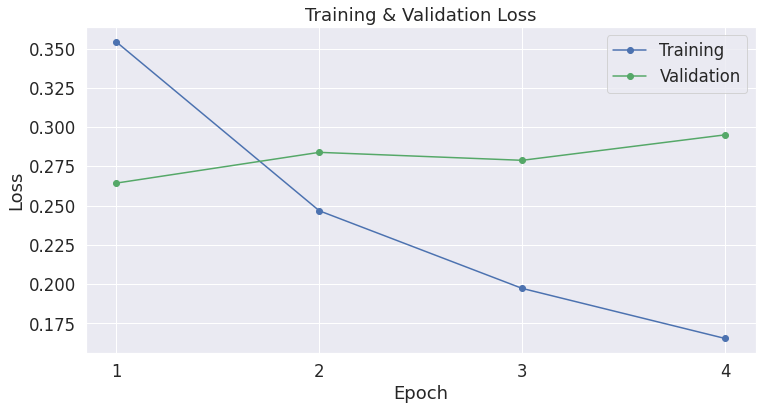

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Performance On Test Set

## Data Preparation

We’ll need to apply all of the same steps that we did for the training data to prepare our test data set.



In [ ]:
test_path = '/content/gdrive/MyDrive/Colab Notebooks/data/test.crash'

with open(test_path, 'r') as f_r:
  data = f_r.read().strip()

  data = re.findall('test_[\s\S]+?\"\n\n', data)

  for sample in data:
    splits = sample.strip().split('\n')

    id = splits[0]
    text = ' '.join(splits[1:])[1:-1]
    text = rdrsegmenter.tokenize(text)
    text = ' '.join([' '.join(x) for x in text])

    test_id.append(id)
    test_text.append(text)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_LEN = 125

test_ids = []

for sent in test_text:
  subwords = '<s>' + phoBERT_bpe.encode(sent) + '</s>'
  encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False)
  test_ids.append(encoded_sent)

test_ids = pad_sequences(test_ids, maxlen = MAX_LEN, dtype = "long", value=0, truncating="post")

In [ ]:
len(test_ids)

10980

In [ ]:
test_masks = []
for sent in test_ids:
  mask = [int(token_id > 0) for token_id in sent]
  test_masks.append(mask)

In [ ]:
# Convert the lists into tensors
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch

test_inputs = torch.tensor(test_ids)
test_masks = torch.tensor(test_masks)

In [ ]:
test_data = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size = 32)

# Try to predict a practical sentence

Now, we can try to test the efficate of our model to classify whatever comments that we type!!! from simple to complicated comments/ feedbacks!


In [ ]:
client_comment = "Đặt lọ 155 k thì đi giao lọ kem khác giá 116k  nhắn tin hỏi thì ko thèm trả lời  mua  trên shope nhiều rùi lần đầu tiên bị 1 hố đau  quá bức xúc"
comment = rdrsegmenter.tokenize(client_comment)
print(comment)

comment_=' '.join([' '.join(x) for x in comment])
print(comment_)

[['Đặt', 'lọ', '155', 'k', 'thì', 'đi', 'giao', 'lọ', 'kem', 'khác', 'giá', '116k', 'nhắn_tin', 'hỏi', 'thì', 'ko', 'thèm', 'trả_lời', 'mua', 'trên', 'shope', 'nhiều', 'rùi', 'lần', 'đầu_tiên', 'bị', '1', 'hố', 'đau', 'quá', 'bức_xúc']]
Đặt lọ 155 k thì đi giao lọ kem khác giá 116k nhắn_tin hỏi thì ko thèm trả_lời mua trên shope nhiều rùi lần đầu_tiên bị 1 hố đau quá bức_xúc


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_LEN = 125

test_ids = []

subwords = '<s>' + phoBERT_bpe.encode(comment_) + '</s>'
encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False)

test_ids.append(encoded_sent)
test_ids = pad_sequences(test_ids, maxlen = MAX_LEN, dtype = "long", value=0, truncating="post")

test_masks = []
for sent in test_ids:
  mask = [int(token_id > 0) for token_id in sent]
  test_masks.append(mask)

# Convert the lists into tensors
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch

test_inputs = torch.tensor(test_ids)
test_masks = torch.tensor(test_masks)

test_data = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size = 32)

In [ ]:
test_inputs.type(),test_masks.type()

('torch.LongTensor', 'torch.LongTensor')

In [ ]:
# 0 is no probem, 1 is having problem

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions  = []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask= batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  
  # Store predictions and true labels
  predictions.append(np.argmax(logits, axis=1).flatten())

print(predictions)

Predicting labels for 1 test sentences...
[array([1])]
